In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Bidirectional, Dropout, Dense, Input, GlobalAveragePooling1D, Multiply, Permute, RepeatVector, Flatten, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-04-03 03:06:46.093136: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 03:06:46.239043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743649606.278117   14220 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743649606.293339   14220 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 03:06:46.407140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load preprocessed data
data = np.load("../dataset.npz")
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

# Debugging: Print shapes and unique classes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (113190, 225), y_train shape: (113190, 35)
X_val shape: (16374, 225), y_val shape: (16374, 35)
X_test shape: (16454, 225), y_test shape: (16454, 35)


In [3]:
# Model Parameters
input_shape = X_train.shape[1:]  # (sequence_length, features)
num_classes = y_train.shape[1]     # Number of output classes

In [4]:
# Reshape data to include the channel dimension (features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Debugging: Verify reshaped data
print(f"Reshaped X_train shape: {X_train.shape}")
print(f"Reshaped X_val shape: {X_val.shape}")
print(f"Reshaped X_test shape: {X_test.shape}")

Reshaped X_train shape: (113190, 225, 1)
Reshaped X_val shape: (16374, 225, 1)
Reshaped X_test shape: (16454, 225, 1)


In [5]:
def sum_over_time(x):
    return tf.keras.backend.sum(x, axis=1)

In [6]:
# Define a simple self-attention block
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    # Learn an attention vector of size (time_steps, 1)
    a = Dense(1, activation='tanh')(inputs)
    a = Flatten()(a)
    a = Activation('softmax')(a)
    a = RepeatVector(input_dim)(a)
    a = Permute([2, 1])(a)
    # Apply the attention weights
    output = Multiply()([inputs, a])
    # Sum over time steps to get a context vector
    output = Lambda(sum_over_time)(output)
    return output

In [7]:
# Input layer
inputs = Input(shape=(X_train.shape[1], 1))

# --- Model Architecture --- #
# First Bidirectional LSTM block
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
x = Dropout(0.4)(x)

# First CNN block
x = Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Second Bidirectional LSTM block
x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
x = Dropout(0.4)(x)

# Second CNN block
x = Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Third Bidirectional LSTM block
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
x = Dropout(0.4)(x)

# Third CNN block
x = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Final LSTM block
x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.3)(x)

# --- Attention Block --- #
attention_output = attention_3d_block(x)

# Dense layers after attention
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(attention_output)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

I0000 00:00:1743649615.841762   14220 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
# Define and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])
model.summary()

# Debugging: Verify model output shape
print(f"Model output shape: {model.output_shape}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 225, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 225, 512)  │    528,384 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 225, 512)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 223, 256)  │    393,472 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 111, 256)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 256)  │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 111, 256)  │    394,240 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 111, 256)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 109, 128)  │     98,432 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 54, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 128)   │        512 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 54, 128)   │     98,816 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 54, 128)   │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 52, 64)    │     24,640 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 26, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 64)    │        256 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 26, 32)    │     12,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 26, 32)    │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 26, 1)     │         33 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 26)        │          0 │ dense[0][0]     

 Total params: 1,560,964 (5.95 MB)

 Trainable params: 1,560,068 (5.95 MB)

 Non-trainable params: 896 (3.50 KB)

Model output shape: (None, 35)


In [9]:
# Callbacks
checkpoint = ModelCheckpoint("../model/best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)


In [10]:
# Train Model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128, 
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Debugging: Print final training and validation accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/100


I0000 00:00:1743649624.822441   14321 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-03 03:07:07.337525: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.0821 - loss: 3.8465
Epoch 1: val_accuracy improved from -inf to 0.25461, saving model to ../model/best_model.keras
885/885 ━━━━━━━━━━━━━━━━━━━━ 186s 199ms/step - accuracy: 0.0821 - loss: 3.8460 - val_accuracy: 0.2546 - val_loss: 2.7286 - learning_rate: 2.0000e-04
Epoch 2/100
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3667 - loss: 2.2932
Epoch 2: val_accuracy improved from 0.25461 to 0.61756, saving model to ../model/best_model.keras
885/885 ━━━━━━━━━━━━━━━━━━━━ 173s 196ms/step - accuracy: 0.3667 - loss: 2.2929 - val_accuracy: 0.6176 - val_loss: 1.4781 - learning_rate: 2.0000e-04
Epoch 3/100
885/885 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6317 - loss: 1.4458
Epoch 3: val_accuracy improved from 0.61756 to 0.73989, saving model to ../model/best_model.keras
885/885 ━━━━━━━━━━━━━━━━━━━━ 174s 197ms/step - accuracy: 0.6318 - loss: 1.4457 - val_accuracy: 0.7399 - val_loss: 1.1382 - learning_rate: 2.0000e-04
Epoch 4

515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.9790 - loss: 0.1997
Test Accuracy: 0.98
515/515 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step


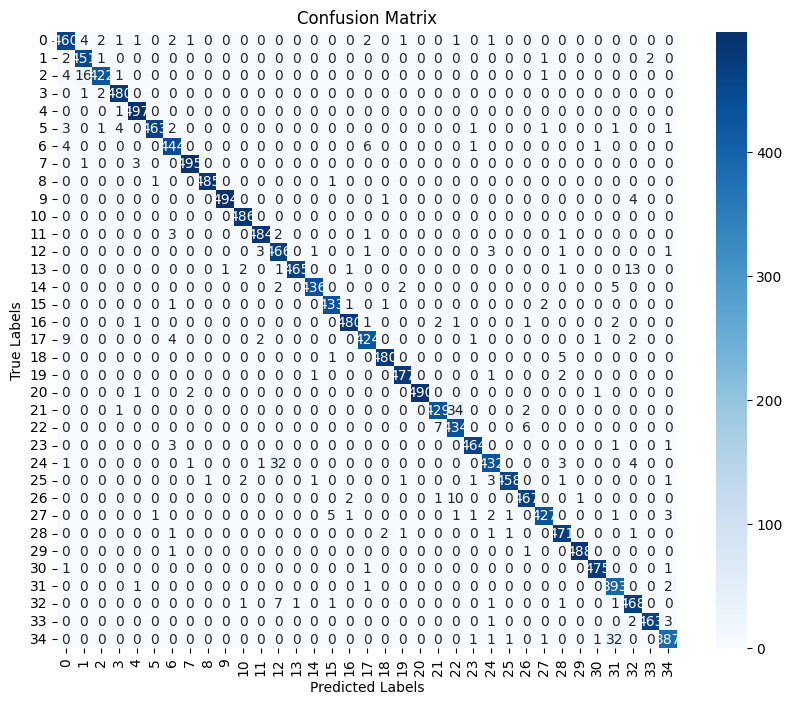

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       476
           1       0.95      0.99      0.97       457
           2       0.99      0.95      0.97       444
           3       0.98      0.99      0.99       483
           4       0.99      1.00      0.99       498
           5       1.00      0.97      0.98       477
           6       0.96      0.97      0.97       456
           7       0.99      0.99      0.99       499
           8       1.00      1.00      1.00       487
           9       1.00      0.99      0.99       499
          10       0.99      1.00      0.99       486
          11       0.99      0.99      0.99       491
          12       0.91      0.98      0.95       476
          13       1.00      0.96      0.98       484
          14       0.99      0.98      0.99       445
          15       0.98      0.99      0.99       438
          16       0.99      0.98      0.99       488
    

In [14]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# --- Confusion Matrix and Classification Report --- #
# Convert predictions and true labels to class indices
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

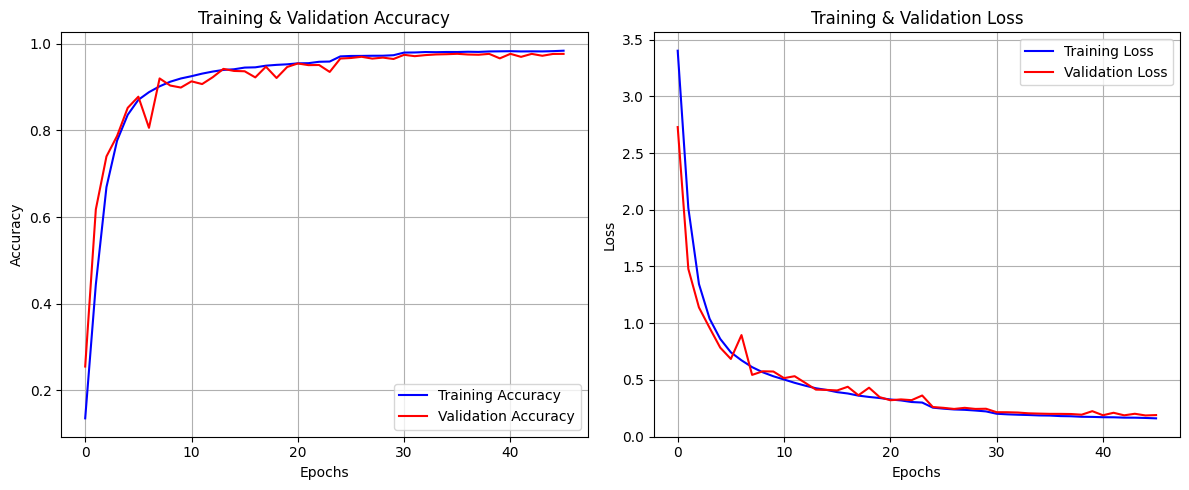

In [15]:
# Plot training history
history_dict = history.history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy", color="blue")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss", color="blue")
plt.plot(history_dict["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [16]:
# Save the final model
model.save("../model/lstm_cnn_model.keras")
print("Model training completed and saved in .keras format.")

Model training completed and saved in .keras format.
